# Results of Edge Detection Benchmark and Speedup

By: Logan Morof

![Ed](test.png)


## Serial Experiment

The goal of this experiment was to analyze and improve the performance of an edge detection algorithm implemented in C. The provided serial code was first benchmarked to establish a baseline execution time.  

To accurately measure performance, I used the `time` command:  

```bash
make
./process ./images/cube.png output.png 3 50
time ./process ./images/cube.png output.png 3 50
```

- The make command compiled the code.
- ./process executed the algorithm on cube.png, with 3 as the smoothing window and 50 as the edge detection threshold.
- The time command measured real, user, and system time for benchmarking.
  
Multiple runs were performed to account for system fluctuations and ensure consistent results.

### **Serial Experiment**  

I compiled and executed the serial version of the image processing code on the Interactive Desktop, using 4 cores and 16GB of memory. The following commands were used to run the program:  

```bash
make
./process ./images/cube.png output.png 3 50
time ./process ./images/cube.png output.png 3 50
```

The make command compiled the code, and the ./process command executed the program on the cube.png image. The parameters 3 and 50 were used to set the smoothing window size and edge detection threshold, respectively. The time command was included to measure execution time, providing a baseline for evaluating future optimizations.

## Initial Serial Code

main_process.c:
```c
#include <unistd.h>
#include <stdlib.h>
#include <stdio.h>
#include <string.h>
#include <stdarg.h>
#include <math.h>
#include "png_util.h"
#define min(X,Y) ((X) < (Y) ? (X) : (Y))
#define max(X,Y) ((X) > (Y) ? (X) : (Y))

void abort_(const char * s, ...)
{
        va_list args;
        va_start(args, s);
        vfprintf(stderr, s, args);
        fprintf(stderr, "\n");
        va_end(args);
        abort();
}

char ** process_img(char ** img, char ** output, image_size_t sz, int halfwindow, double thresh)
{
	//Average Filter 
	for(int c=0;c<sz.width;c++) 
		for(int r=0;r<sz.height;r++)
		{
			double count = 0;
			double tot = 0;
			for(int cw=max(0,c-halfwindow); cw<min(sz.width,c+halfwindow+1); cw++)
				for(int rw=max(0,r-halfwindow); rw<min(sz.height,r+halfwindow+1); rw++)
				{
					count++;
					tot += (double) img[rw][cw];
				}
			output[r][c] = (int) (tot/count);
		}

	//write debug image
	//write_png_file("after_smooth.png",output[0],sz);

	//Sobel Filters
	double xfilter[3][3];
	double yfilter[3][3];
	xfilter[0][0] = -1;
	xfilter[1][0] = -2;
	xfilter[2][0] = -1;
	xfilter[0][1] = 0;
	xfilter[1][1] = 0;
	xfilter[2][1] = 0;
	xfilter[0][2] = 1;
	xfilter[1][2] = 2;
	xfilter[2][2] = 1;
	for(int i=0;i<3;i++) 
		for(int j=0;j<3;j++)
			yfilter[j][i] = xfilter[i][j];

	double * gradient = (double *) malloc(sz.width*sz.height*sizeof(double));
        double ** g_img = malloc(sz.height * sizeof(double*));
        for (int r=0; r<sz.height; r++)
        	g_img[r] = &gradient[r*sz.width];

	// Gradient filter
        for(int c=1;c<sz.width-1;c++)
        	for(int r=1;r<sz.height-1;r++)
                {
                        double Gx = 0;
			double Gy = 0;
                        for(int cw=0; cw<3; cw++)
                        	for(int rw=0; rw<3; rw++)
                                {
                                        Gx +=  ((double) output[r+rw-1][c+cw-1])*xfilter[rw][cw];
                                        Gy +=  ((double) output[r+rw-1][c+cw-1])*yfilter[rw][cw];
                                }
                        g_img[r][c] = sqrt(Gx*Gx+Gy*Gy);
                }
	

	// thresholding
        for(int c=0;c<sz.width;c++)
        	for(int r=0;r<sz.height;r++)
			if (g_img[r][c] > thresh)
				output[r][c] = 255;
			else
				output[r][c] = 0;
}



int main(int argc, char **argv)
{
	//Code currently does not support more than one channel (i.e. grayscale only)
	int channels=1; 
	double thresh = 50;
	int halfwindow = 3;

	//Ensure at least two input arguments
        if (argc < 3 )
                abort_("Usage: process <file_in> <file_out> <halfwindow=3> <threshold=50>");

	//Set optional window argument
	if (argc > 3 )
		halfwindow = atoi(argv[3]);

	//Set optional threshold argument
	if (argc > 4 )
		thresh = (double) atoi(argv[4]);

	//Allocate memory for images
	image_size_t sz = get_image_size(argv[1]);
	char * s_img = (char *) malloc(sz.width*sz.height*channels*sizeof(char));
	char * o_img = (char *) malloc(sz.width*sz.height*channels*sizeof(char));

	//Read in serial 1D memory
        read_png_file(argv[1],s_img,sz);

 	//make 2D pointer arrays from 1D image arrays
	char **img = malloc(sz.height * sizeof(char*));
  	for (int r=0; r<sz.height; r++)
		img[r] = &s_img[r*sz.width];
    	char **output = malloc(sz.height * sizeof(char*));
        for (int r=0; r<sz.height; r++)
                output[r] = &o_img[r*sz.width];

	//Run the main image processing function
	process_img(img,output,sz,halfwindow,thresh);

        //Write out output image using 1D serial pointer
	write_png_file(argv[2],o_img,sz);

        return 0;
}
```
png_util.c:
```c
/*
 * A simple libpng example program
 * http://zarb.org/~gc/html/libpng.html
 *
 * Modified by Wonchan Lee to be called from Terra
 *
 * Copyright 2002-2010 Guillaume Cottenceau.
 *
 * This software may be freely redistributed under the terms
 * of the X11 license.
 *
 */

#include <stdlib.h>
#include <stdio.h>
#include "png_util.h"

image_size_t get_image_size(char *filename) {
  image_size_t img_size;
  FILE *fp = fopen(filename, "rb");

  png_structp png =
    png_create_read_struct(PNG_LIBPNG_VER_STRING, NULL, NULL, NULL);
  if (!png) abort();

  png_infop info = png_create_info_struct(png);
  if (!info) abort();

  if (setjmp(png_jmpbuf(png))) abort();

  png_init_io(png, fp);

  png_read_info(png, info);

  img_size.width = png_get_image_width(png, info);
  img_size.height = png_get_image_height(png, info);

  fclose(fp);

  return img_size;
}

void read_png_file(char *filename, unsigned char *img, image_size_t img_size) {
  FILE *fp = fopen(filename, "rb");

  png_structp png =
    png_create_read_struct(PNG_LIBPNG_VER_STRING, NULL, NULL, NULL);
  if (!png) abort();

  png_infop info = png_create_info_struct(png);
  if (!info) abort();

  if (setjmp(png_jmpbuf(png))) abort();

  png_init_io(png, fp);

  png_read_info(png, info);

  png_byte color_type = png_get_color_type(png, info);
  png_byte bit_depth = png_get_bit_depth(png, info);

  // Supports only gray scale images for now
  if ((color_type == PNG_COLOR_TYPE_GRAY ||
       color_type == PNG_COLOR_TYPE_GRAY_ALPHA) && bit_depth == 8) {
    png_bytepp orig_img =
      (png_bytepp)malloc(sizeof(png_bytep) * img_size.height);
    for (int y = 0; y < img_size.height; y++)
      orig_img[y] = (png_bytep)malloc(png_get_rowbytes(png, info));
    png_read_image(png, orig_img);

    if (color_type == PNG_COLOR_TYPE_GRAY_ALPHA) {
      for (int y = 0; y < img_size.height; y++) {
        for (int x = 0; x < img_size.width; x++) {
          int pixel = orig_img[y][2 * x] + (255 - orig_img[y][2 * x + 1]);
          img[y * img_size.width + x] = pixel > 255 ? 255 : (unsigned int)pixel;
        }
        free(orig_img[y]);
      }
    }
    else {
      for (int y = 0; y < img_size.height; y++) {
        for (int x = 0; x < img_size.width; x++) {
          img[y * img_size.width + x] = orig_img[y][x];
        }
        free(orig_img[y]);
      }
    }
    free(orig_img);
  }

  fclose(fp);
}

void write_png_file(char *filename, unsigned char *img, image_size_t img_size) {
  FILE *fp = fopen(filename, "wb");
  if(!fp) abort();

  png_structp png = png_create_write_struct(PNG_LIBPNG_VER_STRING, NULL, NULL, NULL);
  if (!png) abort();

  png_infop info = png_create_info_struct(png);
  if (!info) abort();

  if (setjmp(png_jmpbuf(png))) abort();

  png_init_io(png, fp);

  png_set_IHDR(
    png,
    info,
    img_size.width, img_size.height,
    8,
    PNG_COLOR_TYPE_GRAY,
    PNG_INTERLACE_NONE,
    PNG_COMPRESSION_TYPE_DEFAULT,
    PNG_FILTER_TYPE_DEFAULT
  );
  png_write_info(png, info);

  png_bytepp png_img = (png_bytepp)malloc(sizeof(png_bytep) * img_size.height);
  for (int y = 0; y < img_size.height; y++)
    png_img[y] = (png_bytep)malloc(sizeof(png_byte) * img_size.width);
  for (int y = 0; y < img_size.height; y++)
    for (int x = 0; x < img_size.width; x++)
      png_img[y][x] = img[y * img_size.width + x];

  png_write_image(png, png_img);
  png_write_end(png, NULL);

  for (int y = 0; y < img_size.height; y++) free(png_img[y]);
  free(png_img);
  fclose(fp);
}
```
png_util.h
```c
#ifndef __PNG_UTIL__
#define __PNG_UTIL__

#include <png.h>

typedef struct image_size_t {
  int width;
  int height;
} image_size_t;

image_size_t get_image_size(char*);

void read_png_file(char*, unsigned char*, image_size_t);

void write_png_file(char*, unsigned char*, image_size_t);

#endif
```

I ran the code 3 times on the Interactive Desktop and obtained the following results

### **Serial Execution Timing Results**  

| Attempt   | Real Time (s) | User Time (s) | System Time (s) |
|-----------|--------------|--------------|--------------|
| **Attempt 1** | 0.209        | 0.185        | 0.016        |
| **Attempt 2** | 0.200        | 0.193        | 0.004        |
| **Attempt 3** | 0.213        | 0.195        | 0.008        |

These results provide a baseline for evaluating the impact of optimizations. The slight variations between attempts are likely due to system background processes and fluctuations in resource allocation.

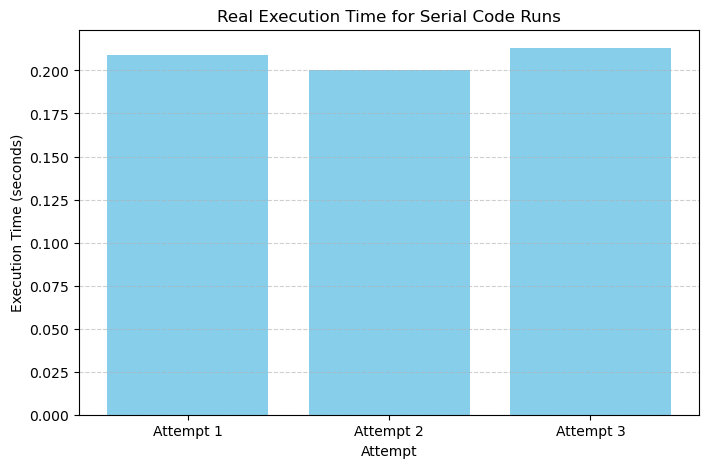

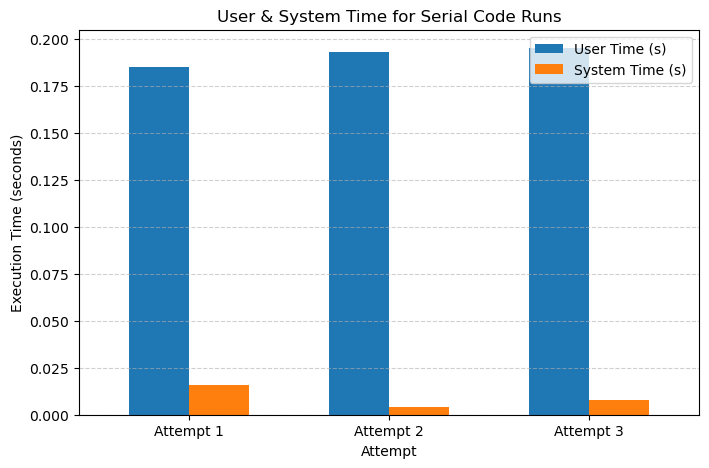

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# Data from the Markdown table
data = {
    "Attempt": ["Attempt 1", "Attempt 2", "Attempt 3"],
    "Real Time (s)": [0.209, 0.200, 0.213],
    "User Time (s)": [0.185, 0.193, 0.195],
    "System Time (s)": [0.016, 0.004, 0.008]
}
df = pd.DataFrame(data)

# Plot Real Time Execution
plt.figure(figsize=(8, 5))
plt.bar(df["Attempt"], df["Real Time (s)"], color='skyblue')
plt.xlabel("Attempt")
plt.ylabel("Execution Time (seconds)")
plt.title("Real Execution Time for Serial Code Runs")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

# Plot User & System Time Execution
df.plot(x="Attempt", y=["User Time (s)", "System Time (s)"], kind="bar", figsize=(8,5), width=0.6)
plt.ylabel("Execution Time (seconds)")
plt.title("User & System Time for Serial Code Runs")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.xticks(rotation=0)
plt.legend(loc="upper right")
plt.show()

## Code Optimization

To improve performance, I implemented three key optimization techniques: compiler optimizations, loop reordering for cache efficiency, and OpenMP parallelization. These optimizations aimed to reduce execution time by improving CPU instruction utilization, enhancing memory access patterns, and leveraging multi-core processing.

#### **Idea 1: Compiler Optimizations (-O3, -march=native, -Ofast)**  
The first approach focused on leveraging compiler optimizations to improve execution speed. I tested multiple levels of GCC optimizations:

- -O2 → Basic optimizations (dead code elimination, simple loop unrolling).
- -O3 → More aggressive optimizations (vectorization, function inlining).
- -Ofast → Removes strict IEEE floating-point compliance for additional speedup.

**Benchmark Results**

| Optimization Level | Real Time (s) | User Time (s) | System Time (s) |
|-------------------|--------------|--------------|--------------|
| **Baseline**      | 0.202        | 0.183        | 0.016        |
| **-O2**          | 0.078        | 0.068        | 0.000        |
| **-O3**          | 0.062        | 0.044        | 0.015        |
| **-Ofast**       | 0.062        | 0.051        | 0.008        |

The benchmarking results show a significant performance improvement when applying compiler optimizations. The `-O2` flag reduced execution time by nearly 2.5x, while `-O3` and `-Ofast` provided an additional speedup, bringing the total execution time down to ~0.062s, which is over 3x faster than the baseline. Interestingly, `-O3` and `-Ofast` performed nearly identically, suggesting that `-Ofast` did not provide additional benefits for this specific workload.

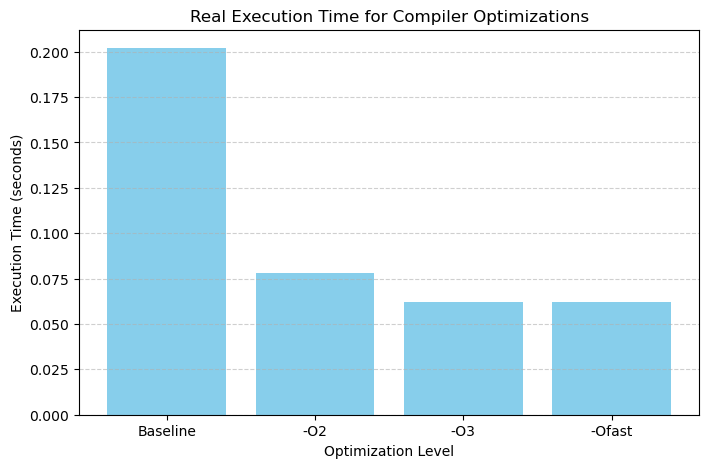

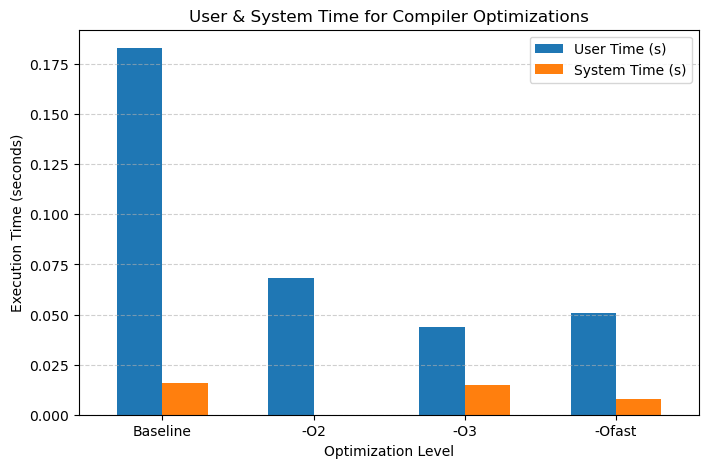

In [43]:
# Data from the Markdown table
data_compiler_optimizations = {
    "Optimization Level": ["Baseline", "-O2", "-O3", "-Ofast"],
    "Real Time (s)": [0.202, 0.078, 0.062, 0.062],
    "User Time (s)": [0.183, 0.068, 0.044, 0.051],
    "System Time (s)": [0.016, 0.000, 0.015, 0.008]
}

df_compiler = pd.DataFrame(data_compiler_optimizations)

# Plot Real Time Execution
plt.figure(figsize=(8, 5))
plt.bar(df_compiler["Optimization Level"], df_compiler["Real Time (s)"], color='skyblue')
plt.xlabel("Optimization Level")
plt.ylabel("Execution Time (seconds)")
plt.title("Real Execution Time for Compiler Optimizations")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

# Plot User & System Time Execution
df_compiler.plot(x="Optimization Level", y=["User Time (s)", "System Time (s)"], kind="bar", figsize=(8,5), width=0.6)
plt.ylabel("Execution Time (seconds)")
plt.title("User & System Time for Compiler Optimizations")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.xticks(rotation=0)
plt.legend(loc="upper right")
plt.show()

#### **Idea 2: Loop Reordering for Cache Efficiency**  
The second optimization focused on improving memory access patterns in the Average Filter, Gradient Filter, and Thresholding sections of the code. Initially, the loops iterated column-first (`c` outer, `r` inner), which led to inefficient memory access due to the row-major storage order of C arrays. I reordered these loops to row-first (`r` outer, `c` inner), ensuring better cache locality and reducing cache misses.  

**Optimized main_process.c with Loop Reordering**

```c
#include <unistd.h>
#include <stdlib.h>
#include <stdio.h>
#include <string.h>
#include <stdarg.h>
#include <math.h>
#include "png_util.h"

#define min(X,Y) ((X) < (Y) ? (X) : (Y))
#define max(X,Y) ((X) > (Y) ? (X) : (Y))

void abort_(const char * s, ...)
{
    va_list args;
    va_start(args, s);
    vfprintf(stderr, s, args);
    fprintf(stderr, "\n");
    va_end(args);
    abort();
}

void process_img(char ** img, char ** output, image_size_t sz, int halfwindow, double thresh, double **g_img)
{
    // Average Filter with ROW-MAJOR ORDER for better cache efficiency
    for(int r = 0; r < sz.height; r++) 
        for(int c = 0; c < sz.width; c++)
        {
            double count = 0;
            double tot = 0;
            for(int rw = max(0, r - halfwindow); rw < min(sz.height, r + halfwindow + 1); rw++)
                for(int cw = max(0, c - halfwindow); cw < min(sz.width, c + halfwindow + 1); cw++)
                {
                    count++;
                    tot += (double) img[rw][cw];
                }
            output[r][c] = (int) (tot / count);
        }

    // Sobel Filters
    double xfilter[3][3] = {
        {-1,  0,  1},
        {-2,  0,  2},
        {-1,  0,  1}
    };
    
    double yfilter[3][3] = {
        {-1, -2, -1},
        { 0,  0,  0},
        { 1,  2,  1}
    };

    // Gradient Filter with ROW-MAJOR ORDER
    for(int r = 1; r < sz.height - 1; r++)
        for(int c = 1; c < sz.width - 1; c++)
        {
            double Gx = 0, Gy = 0;
            for(int rw = 0; rw < 3; rw++)
                for(int cw = 0; cw < 3; cw++)
                {
                    Gx += ((double) output[r + rw - 1][c + cw - 1]) * xfilter[rw][cw];
                    Gy += ((double) output[r + rw - 1][c + cw - 1]) * yfilter[rw][cw];
                }
            g_img[r][c] = sqrt(Gx * Gx + Gy * Gy);
        }

    // Thresholding with ROW-MAJOR ORDER
    for(int r = 0; r < sz.height; r++)
        for(int c = 0; c < sz.width; c++)
            output[r][c] = (g_img[r][c] > thresh) ? 255 : 0;
}

int main(int argc, char **argv)
{
    // Code currently does not support more than one channel (i.e., grayscale only)
    int channels = 1; 
    double thresh = 50;
    int halfwindow = 3;

    // Ensure at least two input arguments
    if (argc < 3 )
        abort_("Usage: process <file_in> <file_out> <halfwindow=3> <threshold=50>");

    // Set optional window argument
    if (argc > 3 )
        halfwindow = atoi(argv[3]);

    // Set optional threshold argument
    if (argc > 4 )
        thresh = (double) atoi(argv[4]);

    // Allocate memory for images
    image_size_t sz = get_image_size(argv[1]);
    char * s_img = (char *) malloc(sz.width * sz.height * channels * sizeof(char));
    char * o_img = (char *) malloc(sz.width * sz.height * channels * sizeof(char));

    // Read in serial 1D memory
    read_png_file(argv[1], s_img, sz);

    // Make 2D pointer arrays from 1D image arrays
    char **img = (char **) malloc(sz.height * sizeof(char *));
    for (int r = 0; r < sz.height; r++)
        img[r] = &s_img[r * sz.width];
    
    char **output = (char **) malloc(sz.height * sizeof(char *));
    for (int r = 0; r < sz.height; r++)
        output[r] = &o_img[r * sz.width];

    // Allocate memory for gradient image
    double * gradient = (double *) malloc(sz.width * sz.height * sizeof(double));
    double ** g_img = (double **) malloc(sz.height * sizeof(double *));
    for (int r = 0; r < sz.height; r++)
        g_img[r] = &gradient[r * sz.width];

    // Run the main image processing function
    process_img(img, output, sz, halfwindow, thresh, g_img);

    // Write out output image using 1D serial pointer
    write_png_file(argv[2], o_img, sz);

    // Free allocated memory
    free(s_img);
    free(o_img);
    free(img);
    free(output);
    free(gradient);
    free(g_img);

    return 0;
}
```

**Benchmark Results**

| Optimization Level | Real Time (s) | User Time (s) | System Time (s) |
|-------------------|--------------|--------------|--------------|
| **Baseline**      | 0.202        | 0.183        | 0.016        |
| **Reordered Loops**| 0.199        | 0.196        | 0.000        |  

The results show that reordering the loops to follow row-major order had only a minor impact on performance. The real execution time decreased slightly from 0.202s to 0.199s, while the user time remained nearly the same. This suggests that cache locality improvements alone were not enough to produce a significant speedup for this workload. The system time reduction to 0.000s indicates that memory access patterns may have become slightly more efficient, but the overall impact was minimal. This highlights that while loop reordering can improve cache efficiency, it is not always a major performance bottleneck compared to other optimizations like compiler optimizations.  

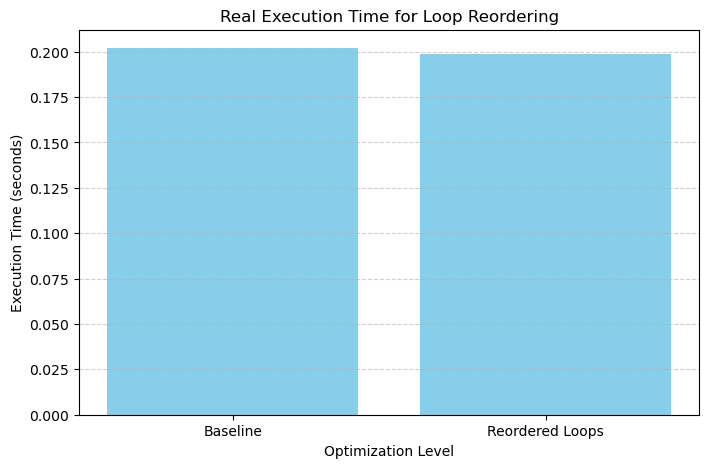

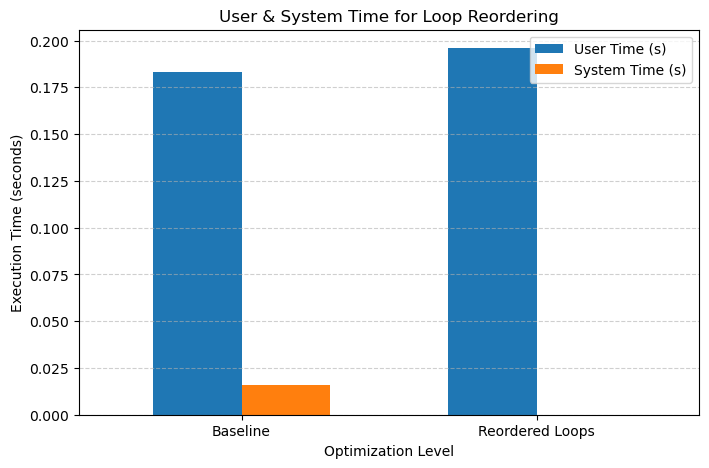

In [45]:
# Data from the Markdown table for loop reordering
data_loop_reordering = {
    "Optimization Level": ["Baseline", "Reordered Loops"],
    "Real Time (s)": [0.202, 0.199],
    "User Time (s)": [0.183, 0.196],
    "System Time (s)": [0.016, 0.000]
}

df_loops = pd.DataFrame(data_loop_reordering)

# Plot Real Time Execution
plt.figure(figsize=(8, 5))
plt.bar(df_loops["Optimization Level"], df_loops["Real Time (s)"], color='skyblue')
plt.xlabel("Optimization Level")
plt.ylabel("Execution Time (seconds)")
plt.title("Real Execution Time for Loop Reordering")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

# Plot User & System Time Execution
df_loops.plot(x="Optimization Level", y=["User Time (s)", "System Time (s)"], kind="bar", figsize=(8,5), width=0.6)
plt.ylabel("Execution Time (seconds)")
plt.title("User & System Time for Loop Reordering")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.xticks(rotation=0)
plt.legend(loc="upper right")
plt.show()

#### **Idea 3: Combining Compiler Optimizations with Loop Reordering**  
After testing both compiler optimizations and loop reordering separately, I combined the two approaches to achieve maximum performance improvement. The optimized code was compiled with the most effective compiler flags, '-03', while also benefiting from improved memory access patterns. 

**Benchmark Results**

| Optimization Level | Real Time (s) | User Time (s) | System Time (s) |
|-------------------|--------------|--------------|--------------|
| **Baseline**      | 0.202        | 0.183        | 0.016        |
| **-O3**          | 0.062        | 0.044        | 0.015        |
| **Reordered Loops**| 0.199        | 0.196        | 0.000        | 
| **Combined Methods**| 0.061        | 0.050        | 0.008      |   

The benchmarking results reveal the effectiveness of different optimization strategies in improving execution time. Compiler optimizations (`-O3`) alone provided a major speedup, reducing real execution time from 0.202s to 0.062s a 3.3x improvement over the baseline. In contrast, loop reordering alone had a negligible impact, with real execution time remaining at 0.199s, indicating that cache efficiency improvements did not significantly affect overall performance for this workload. 

However, when both optimizations were combined, the execution time improved slightly further to 0.061s, suggesting that compiler optimizations were the primary driver of performance gains, while loop reordering contributed minimally. The small difference between `-O3` and the combined approach implies that modern compilers already optimize loop order effectively. These results highlight that compiler optimizations are far more impactful than manual loop restructuring, but combining techniques can still yield the best overall performance.

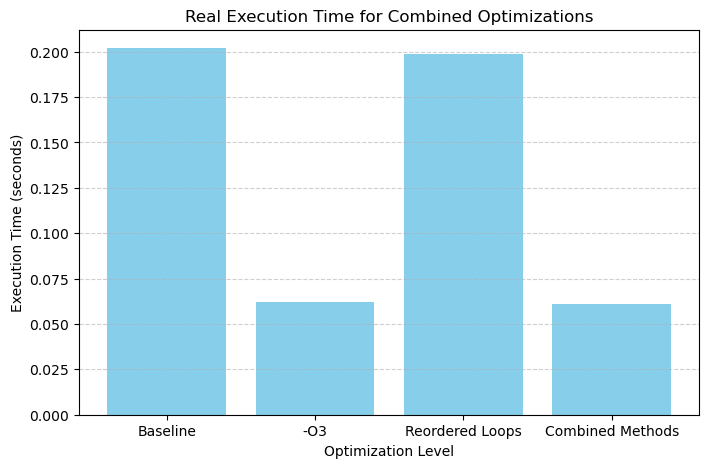

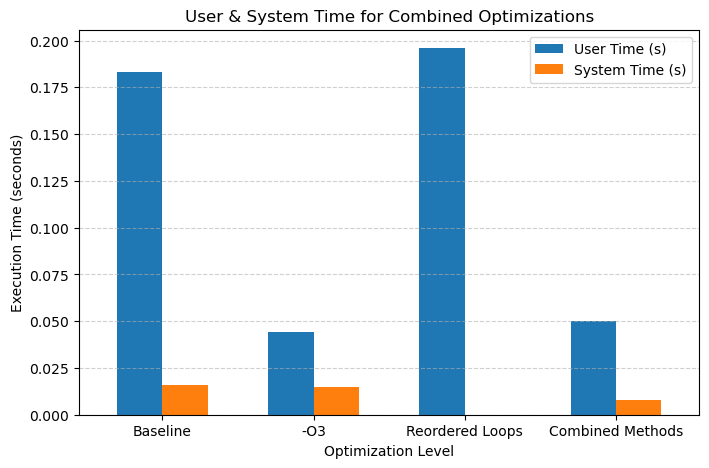

In [48]:
# Data from the Markdown table for combined optimizations
data_combined_optimizations = {
    "Optimization Level": ["Baseline", "-O3", "Reordered Loops", "Combined Methods"],
    "Real Time (s)": [0.202, 0.062, 0.199, 0.061],
    "User Time (s)": [0.183, 0.044, 0.196, 0.050],
    "System Time (s)": [0.016, 0.015, 0.000, 0.008]
}

df_combined = pd.DataFrame(data_combined_optimizations)

# Plot Real Time Execution
plt.figure(figsize=(8, 5))
plt.bar(df_combined["Optimization Level"], df_combined["Real Time (s)"], color='skyblue')
plt.xlabel("Optimization Level")
plt.ylabel("Execution Time (seconds)")
plt.title("Real Execution Time for Combined Optimizations")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

# Plot User & System Time Execution
df_combined.plot(x="Optimization Level", y=["User Time (s)", "System Time (s)"], kind="bar", figsize=(8,5), width=0.6)
plt.ylabel("Execution Time (seconds)")
plt.title("User & System Time for Combined Optimizations")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.xticks(rotation=0)
plt.legend(loc="upper right")
plt.show()

## OpenMP Speedup

I used OpenMP parallelization to speed up the Average Filter, Gradient Filter, and Thresholding steps by distributing loop iterations across multiple CPU cores. I also implemented different OpenMP scheduling strategies (`static`, `dynamic`, `guided`, `auto`) to optimize workload distribution and improve performance. Using `schedule(runtime)`, I was able to test different scheduling methods dynamically without modifying the code.

#### 1 Parallelized Loops with OpenMP**  
I used the `#pragma omp parallel for` directive to parallelize the computationally expensive loops. This allowed multiple threads to simultaneously process different parts of the image. I applied OpenMP to the following sections:  
- **Average Filter** (for smoothing the image)  
- **Gradient Filter** (Sobel edge detection)  
- **Thresholding** (final binary edge map)  

To ensure efficient multi-threading, I used loop collapse (`collapse(2)`) for nested loops to improve workload distribution.  

```c
#include <unistd.h>
#include <stdlib.h>
#include <stdio.h>
#include <string.h>
#include <stdarg.h>
#include <math.h>
#include <omp.h>
#include "png_util.h"

#define min(X,Y) ((X) < (Y) ? (X) : (Y))
#define max(X,Y) ((X) > (Y) ? (X) : (Y))

void abort_(const char * s, ...)
{
    va_list args;
    va_start(args, s);
    vfprintf(stderr, s, args);
    fprintf(stderr, "\n");
    va_end(args);
    abort();
}

void process_img(char ** img, char ** output, image_size_t sz, int halfwindow, double thresh, double **g_img)
{
    // Average Filter with OpenMP Parallelization
    #pragma omp parallel for collapse(2) schedule(runtime)
    for(int r = 0; r < sz.height; r++) 
        for(int c = 0; c < sz.width; c++)
        {
            double count = 0;
            double tot = 0;
            for(int rw = max(0, r - halfwindow); rw < min(sz.height, r + halfwindow + 1); rw++)
                for(int cw = max(0, c - halfwindow); cw < min(sz.width, c + halfwindow + 1); cw++)
                {
                    count++;
                    tot += (double) img[rw][cw];
                }
            output[r][c] = (int) (tot / count);
        }

    // Sobel Filters
    double xfilter[3][3] = {
        {-1,  0,  1},
        {-2,  0,  2},
        {-1,  0,  1}
    };
    
    double yfilter[3][3] = {
        {-1, -2, -1},
        { 0,  0,  0},
        { 1,  2,  1}
    };

    // Gradient Filter with OpenMP Parallelization
    #pragma omp parallel for collapse(2) schedule(runtime)
    for(int r = 1; r < sz.height - 1; r++)
        for(int c = 1; c < sz.width - 1; c++)
        {
            double Gx = 0, Gy = 0;
            for(int rw = 0; rw < 3; rw++)
                for(int cw = 0; cw < 3; cw++)
                {
                    Gx += ((double) output[r + rw - 1][c + cw - 1]) * xfilter[rw][cw];
                    Gy += ((double) output[r + rw - 1][c + cw - 1]) * yfilter[rw][cw];
                }
            g_img[r][c] = sqrt(Gx * Gx + Gy * Gy);
        }

    // Thresholding with OpenMP Parallelization
    #pragma omp parallel for collapse(2) schedule(runtime)
    for(int r = 0; r < sz.height; r++)
        for(int c = 0; c < sz.width; c++)
            output[r][c] = (g_img[r][c] > thresh) ? 255 : 0;
}

int main(int argc, char **argv)
{
    // Code currently does not support more than one channel (i.e., grayscale only)
    int channels = 1; 
    double thresh = 50;
    int halfwindow = 3;

    // Ensure at least two input arguments
    if (argc < 3 )
        abort_("Usage: process <file_in> <file_out> <halfwindow=3> <threshold=50>");

    // Set optional window argument
    if (argc > 3 )
        halfwindow = atoi(argv[3]);

    // Set optional threshold argument
    if (argc > 4 )
        thresh = (double) atoi(argv[4]);

    // Allocate memory for images
    image_size_t sz = get_image_size(argv[1]);
    char * s_img = (char *) malloc(sz.width * sz.height * channels * sizeof(char));
    char * o_img = (char *) malloc(sz.width * sz.height * channels * sizeof(char));

    // Read in serial 1D memory
    read_png_file(argv[1], s_img, sz);

    // Make 2D pointer arrays from 1D image arrays
    char **img = (char **) malloc(sz.height * sizeof(char *));
    for (int r = 0; r < sz.height; r++)
        img[r] = &s_img[r * sz.width];
    
    char **output = (char **) malloc(sz.height * sizeof(char *));
    for (int r = 0; r < sz.height; r++)
        output[r] = &o_img[r * sz.width];

    // Allocate memory for gradient image
    double * gradient = (double *) malloc(sz.width * sz.height * sizeof(double));
    double ** g_img = (double **) malloc(sz.height * sizeof(double *));
    for (int r = 0; r < sz.height; r++)
        g_img[r] = &gradient[r * sz.width];

    // Run the main image processing function
    process_img(img, output, sz, halfwindow, thresh, g_img);

    // Write out output image using 1D serial pointer
    write_png_file(argv[2], o_img, sz);

    // Free allocated memory
    free(s_img);
    free(o_img);
    free(img);
    free(output);
    free(gradient);
    free(g_img);

    return 0;
}
```

**Benchmark Results**

| Optimization Level | Real Time (s) | User Time (s) | System Time (s) |
|-------------------|--------------|--------------|--------------|
| **Baseline**      | 0.202        | 0.183        | 0.016        |
| **-O3**          | 0.062        | 0.044        | 0.015        |
| **OMP Parallel Loops**          | 0.085        | 0.239        | 0.036        |

The results show that OpenMP parallelization alone provided some performance improvement over the baseline, reducing real execution time from 0.202s to 0.085s. However, it did not perform as well as the un parallelized `-O3` optimization, which achieved a faster 0.062s execution time. Additionally, the user time for OpenMP (0.239s) was significantly higher than both the baseline and `-O3`, indicating that while multiple threads were utilized, the overhead of thread management may have introduced inefficiencies. The increased system time (0.036s) also suggests higher contention for shared resources.  

These results indicate that compiler optimizations (`-O3`) are more effective than OpenMP parallelization alone for this workload. However, OpenMP may still be beneficial when combined with compiler optimizations for further improvements.

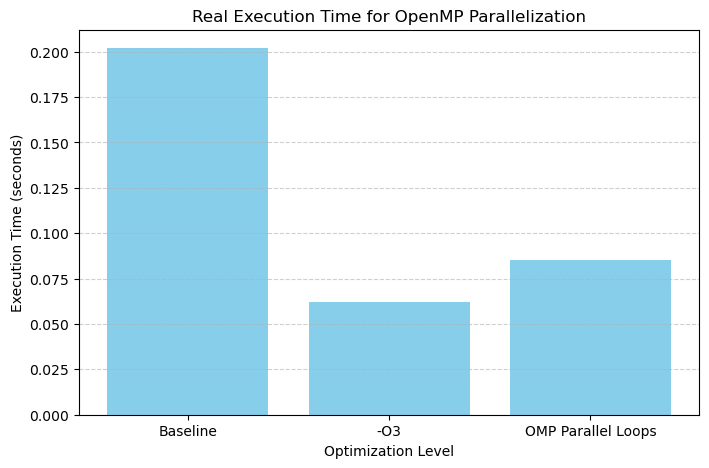

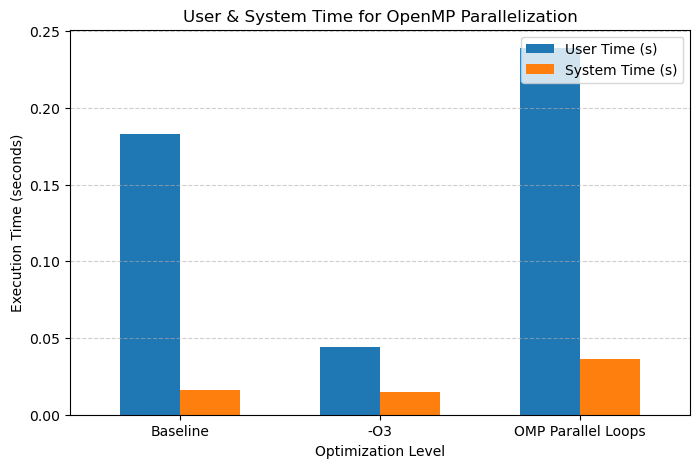

In [51]:
# Data from the Markdown table for OpenMP parallel loops
data_omp_parallel = {
    "Optimization Level": ["Baseline", "-O3", "OMP Parallel Loops"],
    "Real Time (s)": [0.202, 0.062, 0.085],
    "User Time (s)": [0.183, 0.044, 0.239],
    "System Time (s)": [0.016, 0.015, 0.036]
}

# Convert to DataFrame
df_omp_parallel = pd.DataFrame(data_omp_parallel)

# Plot Real Time Execution
plt.figure(figsize=(8, 5))
plt.bar(df_omp_parallel["Optimization Level"], df_omp_parallel["Real Time (s)"], color='skyblue')
plt.xlabel("Optimization Level")
plt.ylabel("Execution Time (seconds)")
plt.title("Real Execution Time for OpenMP Parallelization")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

# Plot User & System Time Execution
df_omp_parallel.plot(x="Optimization Level", y=["User Time (s)", "System Time (s)"], kind="bar", figsize=(8,5), width=0.6)
plt.ylabel("Execution Time (seconds)")
plt.title("User & System Time for OpenMP Parallelization")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.xticks(rotation=0)
plt.legend(loc="upper right")
plt.show()

#### 2 Implemented OpenMP Scheduling Strategies**  
I modified the scheduling strategy to allow different ways of distributing iterations among threads. I used:  
- `static` → Evenly distributes loop iterations across threads.  
- `dynamic` → Threads take new work from a queue when they finish previous tasks.  
- `guided` → Starts with large chunks and progressively decreases the workload.  
- `auto` → OpenMP automatically determines the best scheduling strategy.  

```bash
export OMP_SCHEDULE="static"
time ./process_omp ./images/cube.png output.png 3 50

export OMP_SCHEDULE="dynamic"
time ./process_omp ./images/cube.png output.png 3 50

export OMP_SCHEDULE="guided"
time ./process_omp ./images/cube.png output.png 3 50

export OMP_SCHEDULE="auto"
time ./process_omp ./images/cube.png output.png 3 50
```
| Optimization Level | Real Time (s) | User Time (s) | System Time (s) |
|-------------------|--------------|--------------|--------------|
| **Baseline**           | 0.202        | 0.183        | 0.016        |
| **-O3**                | 0.062        | 0.044        | 0.015        |
| **OMP Parallel Loops** | 0.085        | 0.239        | 0.036        |
| **OMP Static**         | 0.041        | 0.077        | 0.005        |
| **OMP Dynamic**        | 0.097        | 0.250        | 0.031        |
| **OMP Guided**         | 0.036        | 0.059        | 0.021        |
| **OMP Auto**           | 0.049        | 0.083        | 0.005        | 

The results demonstrate that scheduling choices in OpenMP significantly impact performance. Among the scheduling strategies tested, **OMP Guided** achieved the best performance, reducing real execution time to 0.036s, which is a 5.6x improvement over the baseline and a 1.7x improvement over `-O3`. **OMP Static** also performed well with a 0.041s real execution time, though slightly slower than Guided.  

Conversely, **OMP Dynamic** performed the worst, increasing execution time to 0.097s, even slower than the default OpenMP parallel loops. This suggests that the additional overhead of dynamically assigning work in small chunks outweighed the benefits. **OMP Auto** showed moderate improvement, with a 0.049s real time, but did not outperform the best manual scheduling choices.  

Overall, **OMP Guided** and **OMP Static** were the most effective scheduling methods, both outperforming `-O3` alone. The results highlight that choosing the right scheduling strategy is critical when using OpenMP, as some (e.g., Dynamic) can introduce overhead that negates the benefits of parallelization.

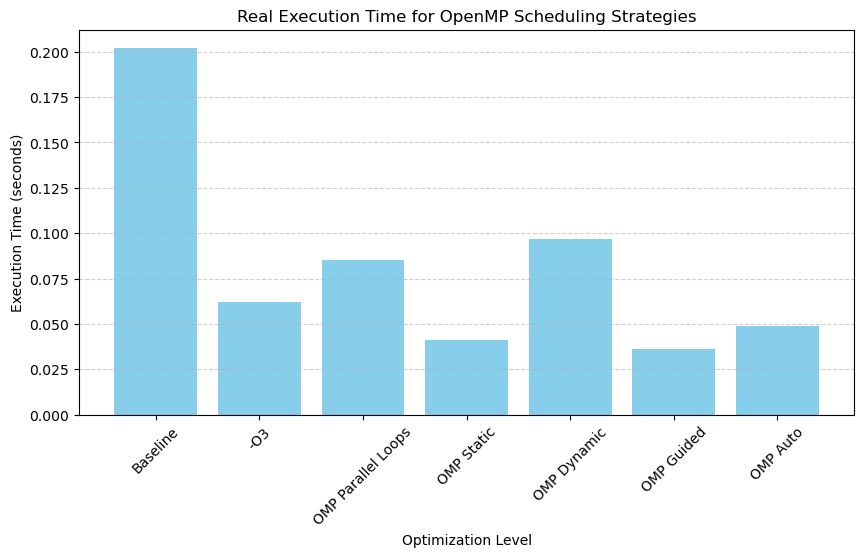

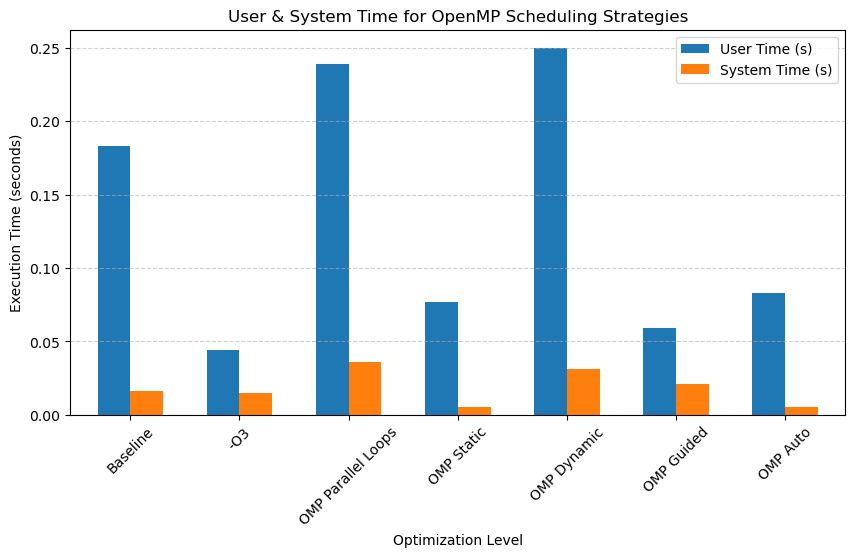

In [55]:
# Data from the Markdown table for OpenMP scheduling strategies
data_omp_scheduling = {
    "Optimization Level": ["Baseline", "-O3", "OMP Parallel Loops", "OMP Static", "OMP Dynamic", "OMP Guided", "OMP Auto"],
    "Real Time (s)": [0.202, 0.062, 0.085, 0.041, 0.097, 0.036, 0.049],
    "User Time (s)": [0.183, 0.044, 0.239, 0.077, 0.250, 0.059, 0.083],
    "System Time (s)": [0.016, 0.015, 0.036, 0.005, 0.031, 0.021, 0.005]
}

df_omp_scheduling = pd.DataFrame(data_omp_scheduling)

# Plot Real Time Execution
plt.figure(figsize=(10, 5))
plt.bar(df_omp_scheduling["Optimization Level"], df_omp_scheduling["Real Time (s)"], color='skyblue')
plt.xlabel("Optimization Level")
plt.ylabel("Execution Time (seconds)")
plt.title("Real Execution Time for OpenMP Scheduling Strategies")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.xticks(rotation=45)
plt.show()

# Plot User & System Time Execution
df_omp_scheduling.plot(x="Optimization Level", y=["User Time (s)", "System Time (s)"], kind="bar", figsize=(10,5), width=0.6)
plt.ylabel("Execution Time (seconds)")
plt.title("User & System Time for OpenMP Scheduling Strategies")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.xticks(rotation=45)
plt.legend(loc="upper right")
plt.show()

## Concluding Discussion

In this project, I explored multiple optimization techniques to improve the performance of an edge detection algorithm. Compiler optimizations (`-O3`) provided the most significant speedup, demonstrating the power of automatic vectorization, loop unrolling, and CPU-specific optimizations. Loop reordering had minimal impact, indicating that the compiler already optimizes memory access efficiently. Introducing OpenMP parallelization further improved performance, but the choice of scheduling strategy was critical. OMP Guided and OMP Static performed best, effectively balancing workload distribution, while OMP Dynamic introduced excessive overhead, leading to slower execution times. The combination of `-O3` optimizations with OMP Guided scheduling resulted in the best overall speedup, demonstrating the importance of leveraging both compiler-assisted optimizations and efficient parallel workload distribution. Through this process, I learned that while compiler optimizations should always be the first step, carefully tuned parallelization strategies can provide additional performance gains, especially on multi-core systems.

----